In [86]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

device = 'cuda'
torch.manual_seed(42)
np.random.seed(42)

## Pretraining
This part should be run if we have want an actual big model. this code will work if you put `BIG_MODEL = True`but take very long time and use resources. Otherwise it will use a standard MLP Nueral Network.
Resnet is pretrained on ImageNet which was big so this will train it on FashionMNIST.

In [87]:
BIG_MODEL = False

In [88]:
if BIG_MODEL:
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

trainset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
testset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

In [89]:
#@title MLP Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)


In [90]:
if BIG_MODEL:
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 10)
else:
    model = MLP()

model = model.to(device)

In [91]:
model

MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [92]:
#@title evaluation function

def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            total += y.size(0)
            correct += (pred == y).sum().item()
    return 100 * correct / total


In [93]:
#@title training function

def train(model, epochs=3, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
        acc = evaluate_accuracy(model, testloader)
        print(f"Epoch {epoch+1}/{epochs} | Test Acc: {acc:.2f}%")


In [94]:
train(model, epochs=3)
model.eval()

Epoch 1/3 | Test Acc: 83.62%
Epoch 2/3 | Test Acc: 85.43%
Epoch 3/3 | Test Acc: 86.92%


MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=10, bias=True)
  )
)

# section 1

In [95]:
if BIG_MODEL:

    conv_weight = model.layer3[0].conv1.weight.data  # shape: [out_channels, in_channels, k, k]

    conv_matrix = conv_weight.clone().detach().reshape(conv_weight.shape[0], -1).cpu().numpy()

    print("Conv matrix shape:", conv_matrix.shape)
else:
    middle_layer = model.net[3]     # nn.Linear(512 → 512)
    middle_weight = middle_layer.weight.data.clone().detach().cpu().numpy()
    print("Middle layer weight shape:", middle_weight.shape)

Middle layer weight shape: (512, 512)


In [108]:
if BIG_MODEL:
    fc_weight = model.fc.weight.data.clone().detach().cpu().numpy()
    print("FC matrix shape:", fc_weight.shape)
else:
    final_layer = model.net[7]      # nn.Linear(512 → 10)
    final_weight = final_layer.weight.data.clone().detach().cpu().numpy()
    final_bias = final_layer.bias.data.clone().detach().cpu().numpy()
    print("Final layer weight shape:", final_weight.shape)
    print("Final layer bias shape:", final_bias.shape)

Final layer weight shape: (10, 512)
Final layer bias shape: (10,)


In [109]:
import matplotlib.pyplot as plt

def spectral_analysis(W, layer_name):
    U, S, Vt = np.linalg.svd(W, full_matrices=False)

    energy = np.cumsum(S**2) / np.sum(S**2)

    k_95 = np.argmax(energy >= 0.95) + 1
    percentage = 100 * k_95 / len(S)

    plt.figure(figsize=(6,4))
    plt.plot(energy, label="Cumulative Explained Variance")
    plt.axhline(0.95, color='red', linestyle='--', label="95% Variance")
    plt.axvline(k_95, color='green', linestyle='--', label=f"k = {k_95}")
    plt.xlabel("Rank")
    plt.ylabel("Explained Variance")
    plt.title(f"Singular Value Spectrum - {layer_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{layer_name}:")
    print(f"  Rank needed for 95% variance: {k_95}")
    print(f"  Percentage of singular values used: {percentage:.2f}%")

    return k_95, percentage


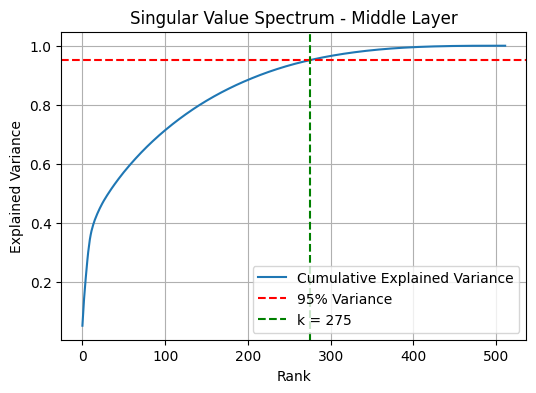

Middle Layer:
  Rank needed for 95% variance: 275
  Percentage of singular values used: 53.71%


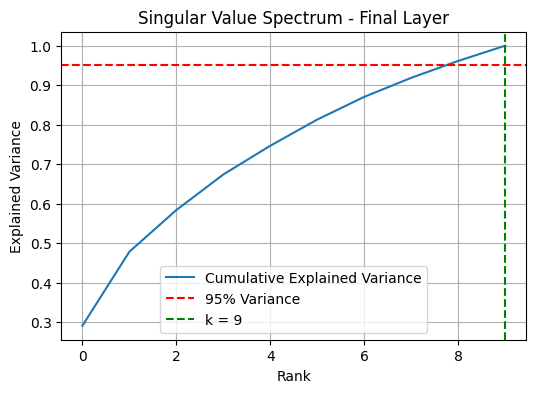

Final Layer:
  Rank needed for 95% variance: 9
  Percentage of singular values used: 90.00%


In [110]:
if BIG_MODEL:
  k_conv, p_conv = spectral_analysis(conv_matrix, "Middle Convolution Layer")
  k_fc, p_fc = spectral_analysis(fc_weight, "Fully Connected Layer")
else:
  k_middle, p_middle = spectral_analysis(middle_weight, "Middle Layer")
  k_final, p_final = spectral_analysis(final_weight, "Final Layer")

# section 2

In [99]:
def compress_linear_layer(linear_layer, rank):

    assert isinstance(linear_layer, nn.Linear)

    W = linear_layer.weight.data
    b = linear_layer.bias.data if linear_layer.bias is not None else None

    U, S, Vh = torch.linalg.svd(W, full_matrices=False)

    U_k = U[:, :rank]
    S_k = S[:rank]
    V_k = Vh[:rank, :]

    layer1 = nn.Linear(V_k.shape[1], rank, bias = False)
    layer1.weight.data = V_k

    layer2 = nn.Linear(rank, U_k.shape[0], bias = b is not None)
    layer2.weight.data = U_k @ torch.diag(S_k)

    if b is not None:
        layer2.bias.data = b

    return nn.Sequential(layer1, layer2).to(device)


In [100]:
import copy

model_orig = model

if BIG_MODEL:

    full_rank = min(model_orig.fc.weight.shape)

    model_50 = copy.deepcopy(model)
    model_50.fc = compress_linear_layer(model_orig.fc, rank=full_rank//2)

    model_80 = copy.deepcopy(model)
    model_80.fc = compress_linear_layer(model_orig.fc, rank=full_rank//5)
else:

    full_rank = min(model_orig.net[3].weight.shape)

    model_50 = copy.deepcopy(model)
    model_50.net[3] = compress_linear_layer(model_orig.net[3], rank=full_rank//2)

    model_80 = copy.deepcopy(model)
    model_80.net[3] = compress_linear_layer(model_orig.net[3], rank=full_rank//5)

model_50 = model_50.to(device)
model_80 = model_80.to(device)

acc_orig = evaluate_accuracy(model_orig, testloader)
acc_50 = evaluate_accuracy(model_50, testloader)
acc_80 = evaluate_accuracy(model_80, testloader)

print(f"Original model accuracy: {acc_orig:.2f}%")
print(f"50% compressed accuracy: {acc_50:.2f}%")
print(f"80% compressed accuracy: {acc_80:.2f}%")


Original model accuracy: 86.92%
50% compressed accuracy: 86.93%
80% compressed accuracy: 86.98%


In [101]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


params_orig = count_parameters(model_orig)
params_50   = count_parameters(model_50)
params_80   = count_parameters(model_80)

print("Original parameters:", params_orig)
print("50% compressed parameters:", params_50)
print("80% compressed parameters:", params_80)


Original parameters: 932362
50% compressed parameters: 932362
80% compressed parameters: 774666


# section 3

In [102]:
def fine_tune(model, trainloader, epochs=3, lr=1e-4, device="cpu"):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    return model


In [103]:
print("Fine-tuning 50% compressed model")
model_50_ft = fine_tune(model_50, trainloader, epochs=3, device=device)

print("\nFine-tuning 80% compressed model")
model_80_ft = fine_tune(model_80, trainloader, epochs=3, device=device)

Fine-tuning 50% compressed model
Epoch [1/3] - Loss: 0.2588
Epoch [2/3] - Loss: 0.2417
Epoch [3/3] - Loss: 0.2310

Fine-tuning 80% compressed model
Epoch [1/3] - Loss: 0.2604
Epoch [2/3] - Loss: 0.2446
Epoch [3/3] - Loss: 0.2347


In [104]:
acc_orig = evaluate_accuracy(model_orig, testloader)
acc_50_ft = evaluate_accuracy(model_50_ft, testloader)
acc_80_ft = evaluate_accuracy(model_80_ft, testloader)

print(f"Original model accuracy: {acc_orig:.2f}%")
print(f"50% compressed (FT) accuracy: {acc_50_ft:.2f}%")
print(f"80% compressed (FT) accuracy: {acc_80_ft:.2f}%")


Original model accuracy: 86.91%
50% compressed (FT) accuracy: 88.75%
80% compressed (FT) accuracy: 88.66%


In [105]:
def measure_inference_time(model, input_tensor, runs=100):
    model.to('cpu')
    model.eval()
    with torch.no_grad():
        # warm-up
        for _ in range(10):
            model(input_tensor)

        start = time.time()
        for _ in range(runs):
            model(input_tensor)
        end = time.time()
    model.to(device)
    return (end - start) / runs


In [106]:
if BIG_MODEL:
    dummy_input = torch.randn(1, 3, 224, 224).to('cpu')
else:
    dummy_input = torch.randn(1, 1, 28, 28).to('cpu')

time_orig = measure_inference_time(model_orig, dummy_input)
time_50   = measure_inference_time(model_50_ft, dummy_input)
time_80   = measure_inference_time(model_80_ft, dummy_input)

print(f"Original model inference time: {time_orig*1000:.2f} ms")
print(f"50% compressed inference time: {time_50*1000:.2f} ms")
print(f"80% compressed inference time: {time_80*1000:.2f} ms")


Original model inference time: 0.29 ms
50% compressed inference time: 0.30 ms
80% compressed inference time: 0.26 ms


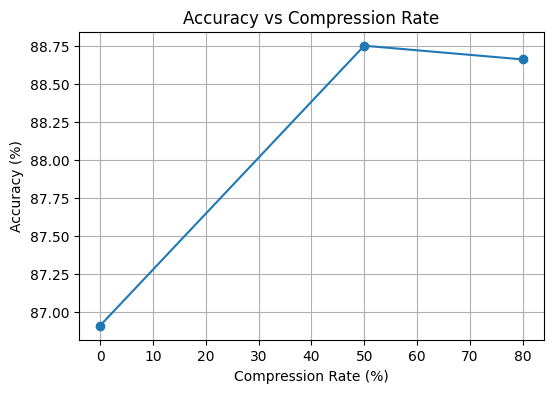

In [107]:
compression_rates = [0, 50, 80]
accuracies = [acc_orig, acc_50_ft, acc_80_ft]

plt.figure(figsize=(6,4))
plt.plot(compression_rates, accuracies, marker='o')
plt.xlabel("Compression Rate (%)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Compression Rate")
plt.grid(True)
plt.show()
